#**Import & prepare Dataset**

In [13]:
!pip install mediapipe
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin, sqrt
from pathlib import Path
import pandas as pd
import seaborn as sns
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##**Download dataset**

In [2]:
# download AFLW2000 Data
!wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip
!unzip /content/AFLW2000-3D.zip


Streaming output truncated to the last 5000 lines.
  inflating: AFLW2000/image01486.jpg  
  inflating: AFLW2000/image01486.mat  
  inflating: AFLW2000/image01488.jpg  
  inflating: AFLW2000/image01488.mat  
  inflating: AFLW2000/image01496.jpg  
  inflating: AFLW2000/image01496.mat  
  inflating: AFLW2000/image01503.jpg  
  inflating: AFLW2000/image01503.mat  
  inflating: AFLW2000/image01504.jpg  
  inflating: AFLW2000/image01504.mat  
  inflating: AFLW2000/image01505.jpg  
  inflating: AFLW2000/image01505.mat  
  inflating: AFLW2000/image01506.jpg  
  inflating: AFLW2000/image01506.mat  
  inflating: AFLW2000/image01507.jpg  
  inflating: AFLW2000/image01507.mat  
  inflating: AFLW2000/image01509.jpg  
  inflating: AFLW2000/image01509.mat  
  inflating: AFLW2000/image01513.jpg  
  inflating: AFLW2000/image01513.mat  
  inflating: AFLW2000/image01514.jpg  
  inflating: AFLW2000/image01514.mat  
  inflating: AFLW2000/image01530.jpg  
  inflating: AFLW2000/image01530.mat  
  inflating: 

##**Helper Functions**

In [8]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [9]:
def fetch(data_dir):
    images = []
    landmarks = []
    angles = []
    with mediapipe.solutions.face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
        for filename in sorted(os.listdir(data_dir)):
            if not filename.endswith('.jpg'):
                continue
            filepath = os.path.join(data_dir, filename)
            image = cv2.imread(filepath)
            results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            landmarks_per_image = []
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    for landmark in face_landmarks.landmark:
                        x = landmark.x * image.shape[1]
                        y = landmark.y * image.shape[0]
                        landmarks_per_image.extend([int(x), int(y)])
            mat_filepath = os.path.join(data_dir, filename[:-4] + '.mat')
            pose_para = sio.loadmat(mat_filepath)["Pose_Para"][0][:3]
            images.append(image)
            landmarks.append(landmarks_per_image)
            angles.append(pose_para)
    return images, landmarks, angles


In [10]:
def normalize_features(features):
    x_cols = [col for col in features.columns if col.startswith('X')]
    y_cols = [col for col in features.columns if col.startswith('Y')]
    
    x_means = features[x_cols].iloc[:, 1:].mean(axis=1)
    y_means = features[y_cols].iloc[:, 1:].mean(axis=1)

    features[x_cols] = (features[x_cols] - x_means.to_numpy().reshape(-1, 1))
    features[y_cols] = (features[y_cols] - y_means.to_numpy().reshape(-1, 1))
    
    forehead = np.array([features.loc[:, 'X_10'], features.loc[:, 'Y_10']]).T
    chin = np.array([features.loc[:, 'X_152'], features.loc[:, 'Y_152']]).T
    forehead_chin_distance = np.linalg.norm(chin - forehead, axis=1).reshape(-1, 1)
    
    return features / forehead_chin_distance

##**Prepare Dataset**

In [14]:
images, landmarks, angles = fetch('/content/AFLW2000')

In [15]:
landmarks_df = pd.DataFrame(landmarks)
landmarks_df.columns = [f"X_{i//2}" if i%2==0 else f"Y_{i//2}" for i in range(len(landmarks_df.columns))]
landmarks_df.head()

,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,...,X_463,Y_463,X_464,Y_464,X_465,Y_465,X_466,Y_466,X_467,Y_467
0,218.0,309.0,220.0,287.0,220.0,291.0,215.0,253.0,220.0,279.0,...,251.0,218.0,246.0,221.0,243.0,225.0,299.0,212.0,304.0,208.0
1,198.0,288.0,187.0,266.0,201.0,274.0,196.0,245.0,187.0,259.0,...,235.0,228.0,230.0,230.0,225.0,231.0,263.0,225.0,267.0,222.0
2,143.0,359.0,144.0,349.0,143.0,351.0,139.0,335.0,144.0,345.0,...,150.0,323.0,148.0,324.0,147.0,325.0,168.0,320.0,169.0,319.0
3,226.0,312.0,211.0,294.0,220.0,296.0,199.0,265.0,207.0,286.0,...,228.0,225.0,223.0,229.0,220.0,233.0,268.0,205.0,271.0,200.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
angles_df = pd.DataFrame(angles, columns=['Pitch', 'Yaw', 'Roll'])
angles_df.head()

,Pitch,Yaw,Roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.882169,1.198004,-1.033374


In [17]:
dataset = landmarks_df.join(angles_df)
dataset.head()

,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,...,Y_464,X_465,Y_465,X_466,Y_466,X_467,Y_467,Pitch,Yaw,Roll
0,218.0,309.0,220.0,287.0,220.0,291.0,215.0,253.0,220.0,279.0,...,221.0,243.0,225.0,299.0,212.0,304.0,208.0,-0.399231,0.018227,0.085676
1,198.0,288.0,187.0,266.0,201.0,274.0,196.0,245.0,187.0,259.0,...,230.0,225.0,231.0,263.0,225.0,267.0,222.0,0.470065,1.189533,0.300959
2,143.0,359.0,144.0,349.0,143.0,351.0,139.0,335.0,144.0,345.0,...,324.0,147.0,325.0,168.0,320.0,169.0,319.0,-0.184650,0.881137,-0.236852
3,226.0,312.0,211.0,294.0,220.0,296.0,199.0,265.0,207.0,286.0,...,229.0,220.0,233.0,268.0,205.0,271.0,200.0,-0.175379,0.299208,-0.373374
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.882169,1.198004,-1.033374


In [18]:
dataset = dataset.dropna()
dataset.shape

(1853, 939)

In [19]:
X = dataset.iloc[:,:-3].copy()
y = dataset.iloc[:,-3:].copy()

In [20]:
X_normalized = normalize_features(X.copy())
X_normalized.head()

,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,...,X_463,Y_463,X_464,Y_464,X_465,Y_465,X_466,Y_466,X_467,Y_467
0,-0.026605,0.203146,-0.018258,0.111328,-0.018258,0.128022,-0.039126,-0.030573,-0.018258,0.077939,...,0.111122,-0.176648,0.090254,-0.164127,0.077734,-0.147433,0.311453,-0.201689,0.332320,-0.218383
1,-0.152307,0.168426,-0.219791,0.033459,-0.133903,0.082538,-0.164577,-0.095373,-0.219791,-0.009485,...,0.074682,-0.199665,0.044008,-0.187395,0.013334,-0.181261,0.246458,-0.218070,0.270998,-0.236474
2,0.028839,0.165186,0.038641,0.067166,0.028839,0.086770,-0.010369,-0.070063,0.038641,0.027958,...,0.097454,-0.187687,0.077850,-0.177885,0.068048,-0.168083,0.273890,-0.217093,0.283692,-0.226895
3,0.008941,0.216086,-0.064226,0.128286,-0.020326,0.138041,-0.122760,-0.013171,-0.083738,0.089263,...,0.018697,-0.208284,-0.005693,-0.188773,-0.020326,-0.169261,0.213809,-0.305840,0.228443,-0.330229
5,0.022569,0.167069,-0.012534,0.039820,0.000630,0.079311,-0.060801,-0.083041,-0.021310,0.000329,...,0.044509,-0.205903,0.022569,-0.192739,0.013793,-0.183963,0.206861,-0.262946,0.224413,-0.271721


#**Models**

##**Helper Functions**

In [21]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from sklearn.tree import DecisionTreeRegressor

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred):
  """
  y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

  y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.
  """
  metrics = {
      'R2 Score': r2_score,
      'MSE': mean_squared_error,
      'MAE': mean_absolute_error
  }
  
  for i, label in enumerate(['Pitch', 'Yaw', 'Roll']):
    print(f'{label} regressor:')
    
    for metric_name, metric_func in metrics.items():
      metric_value = metric_func(y_true[:,i], y_pred[:,i])
      print(f'{metric_name}: {metric_value:.4f}')


In [60]:
def get_features(image):
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            # extract x, y coordinates of all landmarks and scale to image dimensions
            landmarks = np.array([(lmk.x * image.shape[1], lmk.y * image.shape[0]) 
                                  for face in results.multi_face_landmarks 
                                  for lmk in face.landmark]).flatten()
    return landmarks.reshape(1, -1)

In [58]:
def predict_angles(image_path, model):
    """
    Predicts the pose angles (pitch, yaw, roll) of the face in the given image
    using the given regression model.

    Args:
    - image_path (str): Path to the image file.
    - model (Regressor): Trained regression model.

    Returns:
    - img_pred (numpy.ndarray): The input image with the predicted pose angles drawn
                                on it using colored axes.
    """

    # Load the image and extract its features
    image = cv2.imread(image_path)
    features = get_features(image)

    if features.size:
        # Convert features to DataFrame and normalize them
        features_df = pd.DataFrame(features, columns=X.columns)
        nose = np.array(list(zip(features_df['X_1'], features_df['Y_1']))).squeeze()
        features_df = normalize_features(features_df)

        # Predict pose angles using the model
        pred = model.predict(features_df.values).squeeze()

        # Draw colored axes on the input image based on the predicted pose angles
        img_pred = draw_axis(image.copy(), pred[0], pred[1], pred[2], tdx=nose[0], tdy=nose[1])
        
        return img_pred
    else:
        return None


##**ML Models**

##**XGBoost**

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(X_normalized.values, y.values, test_size=0.2, random_state=42)

In [18]:
import xgboost
from xgboost import XGBRegressor

xgboost_regressor = XGBRegressor(learning_rate=0.1, verbosity=0, max_depth=9, n_estimators=200)
multi_xgboost = MultiOutputRegressor(xgboost_regressor)
multi_xgboost.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(max_depth=9, n_estimators=200,
                                            verbosity=0))

In [19]:
evaluate_model(y_test, multi_xgboost.predict(X_test))

Pitch regressor:
R2 Score: 0.7332
MSE: 0.0195
MAE: 0.0826
Yaw regressor:
R2 Score: 0.8652
MSE: 0.0341
MAE: 0.0770
Roll regressor:
R2 Score: 0.7313
MSE: 0.0271
MAE: 0.0615


##**SVM**

In [26]:
svr = SVR(C=100, gamma=0.01)
multi_svr = MultiOutputRegressor(svr)
multi_svr.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR(C=100, gamma=0.01))

In [27]:
evaluate_model(y_test, multi_svr.predict(X_test))

Pitch regressor:
R2 Score: 0.6472
MSE: 0.0258
MAE: 0.0828
Yaw regressor:
R2 Score: 0.9403
MSE: 0.0151
MAE: 0.0617
Roll regressor:
R2 Score: 0.8848
MSE: 0.0116
MAE: 0.0557


##**Grid Search with SVR**

In [23]:
param_grid = {
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__C': scipy.stats.expon(scale=5),
    'estimator__degree': np.arange(2, 6),
    'estimator__coef0': np.arange(0, 6),
    'estimator__gamma': scipy.stats.expon(scale=.1),
    'estimator__epsilon': scipy.stats.expon(scale=.1)
}

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
random_search = RandomizedSearchCV(multi_out_svr, param_grid, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
svr_model = random_search.best_estimator_
#Evaluate the model
print('best parameters: ', random_search.best_params_)

best parameters:  {'estimator__C': 1.4972888842034304, 'estimator__coef0': 3, 'estimator__degree': 3, 'estimator__epsilon': 0.05536563610069876, 'estimator__gamma': 0.023312023188561702, 'estimator__kernel': 'poly'}


In [24]:
evaluate_model(y_test, svr_model.predict(X_test))

Pitch regressor:
R2 Score: 0.6908
MSE: 0.0226
MAE: 0.0798
Yaw regressor:
R2 Score: 0.9508
MSE: 0.0125
MAE: 0.0605
Roll regressor:
R2 Score: 0.8952
MSE: 0.0106
MAE: 0.0491


##**Grid Search with Decision Trees**

In [27]:
param_grid = {
    'estimator__max_depth': np.arange(2, 10),
    'estimator__min_samples_split': np.logspace(1, 7, 7, base=2).astype(int),
    'estimator__min_samples_leaf': np.logspace(0, 6, 7, base=2).astype(int),
    'estimator__max_features': np.arange(4, 15),
    'estimator__ccp_alpha': scipy.stats.expon(scale=.1),
}

reg_tree = DecisionTreeRegressor(random_state=42)
multi_out_tree = MultiOutputRegressor(reg_tree)

random_search = RandomizedSearchCV(multi_out_tree, param_grid, scoring='neg_mean_squared_error', n_iter=40)
random_search.fit(X_train, y_train)
tree_model = random_search.best_estimator_

In [28]:
evaluate_model(y_test, tree_model.predict(X_test))

Pitch regressor:
R2 Score: 0.2169
MSE: 0.0572
MAE: 0.1670
Yaw regressor:
R2 Score: 0.7124
MSE: 0.0728
MAE: 0.1981
Roll regressor:
R2 Score: 0.5285
MSE: 0.0475
MAE: 0.1395


##**Results**

**The best model was obtained from grid search with SVR**

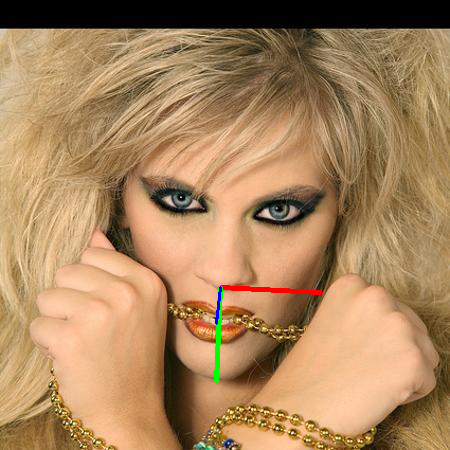

In [62]:
image_path = '/content/AFLW2000/image00002.jpg'
model = multi_svr  # or multi_xgboost or svr_model

img_pred = predict_angles(image_path, model)
if img_pred is not None:
    cv2_imshow(img_pred)
else:
    print(f"No face detected in {image_path}")


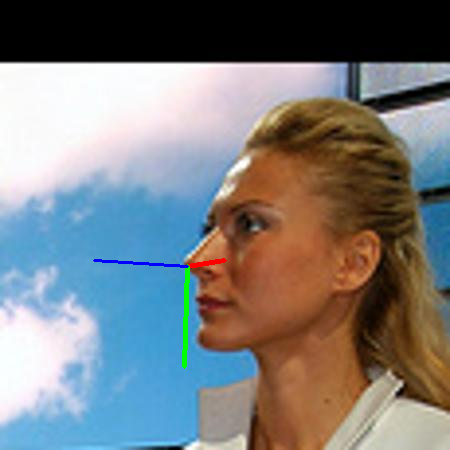

In [63]:
image_path = '/content/AFLW2000/image00004.jpg'
model = multi_svr  # or multi_xgboost

img_pred = predict_angles(image_path, model)
if img_pred is not None:
    cv2_imshow(img_pred)
else:
    print(f"No face detected in {image_path}")

#**Video**

##**Helper Functions**

In [ ]:
!pip install acapture

In [69]:
def process_video(video_path, model):
    cap = cv2.VideoCapture(video_path)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        features = get_features(frame)
        if features.size:
            features_df = pd.DataFrame(features, columns=X.columns)
            nose = np.array(list(zip(features_df['X_1'], features_df['Y_1']))).squeeze()
            features_df = normalize_features(features_df)
            pred = model.predict(features_df.values).squeeze()
            draw_axis(frame, pred[0], pred[1], pred[2], tdx=nose[0], tdy=nose[1])
            out.write(frame)

    out.release()
    cv2.destroyAllWindows()


##**test**

In [ ]:
PATH = "afsha.mp4"
process_video(PATH, multi_svr)  # or pass any other trained model